# Demo: Building Variational Autoencoders in Pytorch

Adapted from: https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/VAE_mnist.ipynb

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Adapted From: Eugenia Anello, Variational Autoencoder with Pytorch, Dataseries (Medium)<br>
Date: Jun 28, 2021

In [1]:
!pip list | grep -e qiskit -e torch

qiskit                        0.44.2
qiskit-aer                    0.13.0
qiskit-algorithms             0.2.1
qiskit-finance                0.3.4
qiskit-machine-learning       0.7.0
qiskit-nature                 0.6.2
qiskit-optimization           0.5.0
qiskit-qasm3-import           0.2.0
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.25.2.1
torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

## Prelims: Get data and create tensor data loaders

In [3]:
data_dir = '../dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [6]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, latent_dims):
        
        super(VariationalEncoder, self).__init__()
        
        # Create all layers
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        
        # self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z

In [7]:
### Traditional decoder
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)
        
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss
*Note that "d" is the size of a latent space*

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [10]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [11]:
### Testing function
def test_epoch(vae, device, dataloader):
    
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            
            # Move tensor to the proper device
            x = x.to(device)
            
            # Encode data
            encoded_data = vae.encoder(x)
            
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [12]:
def plot_ae_outputs(encoder,decoder,n=5):
    
    plt.figure(figsize=(10,4.5))
    
    for i in range(n):
        
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

        if i == n//2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.show()   

	 partial train loss (single batch): 69173.625000
	 partial train loss (single batch): 67813.906250
	 partial train loss (single batch): 65967.929688
	 partial train loss (single batch): 64729.910156
	 partial train loss (single batch): 63617.359375
	 partial train loss (single batch): 62406.234375
	 partial train loss (single batch): 61467.761719
	 partial train loss (single batch): 60354.507812
	 partial train loss (single batch): 59748.531250
	 partial train loss (single batch): 59179.609375
	 partial train loss (single batch): 58708.695312
	 partial train loss (single batch): 58817.847656
	 partial train loss (single batch): 57860.335938
	 partial train loss (single batch): 57084.492188
	 partial train loss (single batch): 56917.242188
	 partial train loss (single batch): 56426.000000
	 partial train loss (single batch): 56059.730469
	 partial train loss (single batch): 55493.355469
	 partial train loss (single batch): 55092.238281
	 partial train loss (single batch): 54882.152344


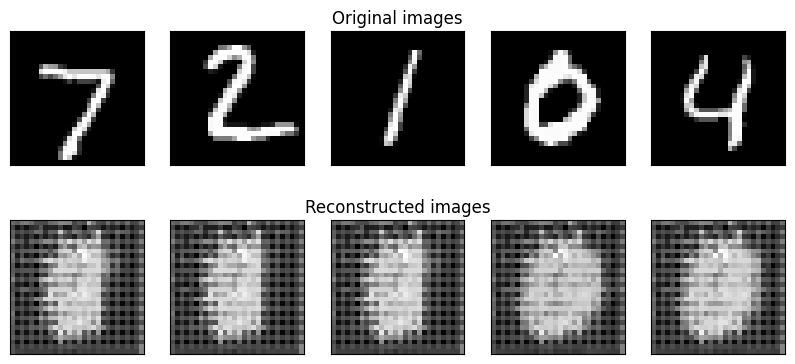

	 partial train loss (single batch): 19755.169922
	 partial train loss (single batch): 19648.992188
	 partial train loss (single batch): 19678.191406
	 partial train loss (single batch): 19510.853516
	 partial train loss (single batch): 19413.966797
	 partial train loss (single batch): 19407.603516
	 partial train loss (single batch): 19330.826172
	 partial train loss (single batch): 19416.718750
	 partial train loss (single batch): 19286.154297
	 partial train loss (single batch): 19089.787109
	 partial train loss (single batch): 19046.349609
	 partial train loss (single batch): 18803.367188
	 partial train loss (single batch): 18921.611328
	 partial train loss (single batch): 19132.304688
	 partial train loss (single batch): 18724.783203
	 partial train loss (single batch): 18744.818359
	 partial train loss (single batch): 18481.873047
	 partial train loss (single batch): 18720.283203
	 partial train loss (single batch): 18451.582031
	 partial train loss (single batch): 18378.677734


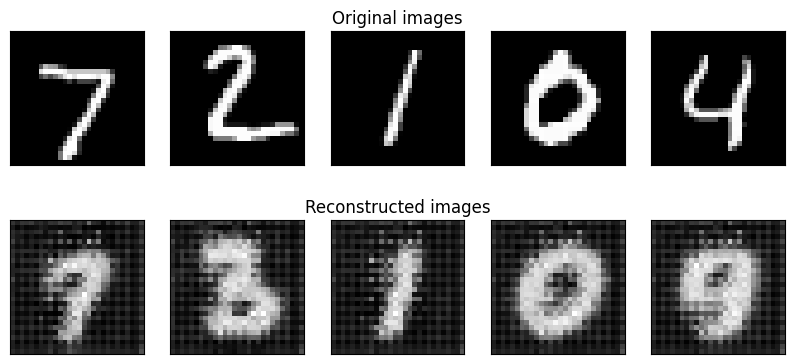

	 partial train loss (single batch): 13253.540039
	 partial train loss (single batch): 13250.342773
	 partial train loss (single batch): 13266.445312
	 partial train loss (single batch): 13104.513672
	 partial train loss (single batch): 13227.984375
	 partial train loss (single batch): 13098.882812
	 partial train loss (single batch): 13091.712891
	 partial train loss (single batch): 13362.855469
	 partial train loss (single batch): 13291.291016
	 partial train loss (single batch): 13033.840820
	 partial train loss (single batch): 13129.717773
	 partial train loss (single batch): 12638.335938
	 partial train loss (single batch): 13056.183594
	 partial train loss (single batch): 13306.677734
	 partial train loss (single batch): 12924.701172
	 partial train loss (single batch): 12924.073242
	 partial train loss (single batch): 12860.843750
	 partial train loss (single batch): 13163.454102
	 partial train loss (single batch): 12867.522461
	 partial train loss (single batch): 12836.376953


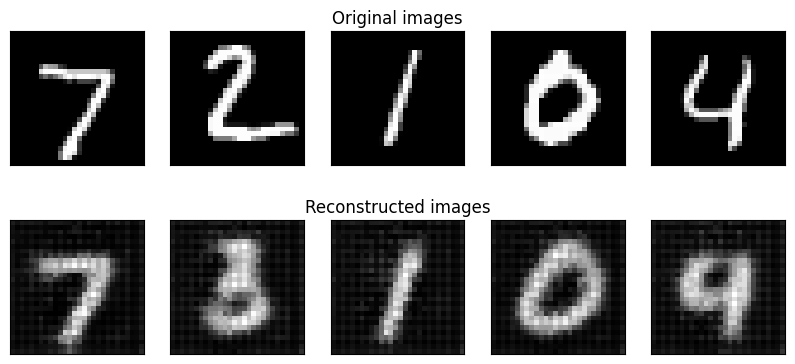

	 partial train loss (single batch): 11011.628906
	 partial train loss (single batch): 10937.995117
	 partial train loss (single batch): 10949.509766
	 partial train loss (single batch): 10787.725586
	 partial train loss (single batch): 10797.487305
	 partial train loss (single batch): 10814.779297
	 partial train loss (single batch): 10792.333008
	 partial train loss (single batch): 11080.621094
	 partial train loss (single batch): 10978.902344
	 partial train loss (single batch): 10633.335938
	 partial train loss (single batch): 10826.092773
	 partial train loss (single batch): 10273.517578
	 partial train loss (single batch): 10768.449219
	 partial train loss (single batch): 10986.739258
	 partial train loss (single batch): 10654.380859
	 partial train loss (single batch): 10581.562500
	 partial train loss (single batch): 10638.174805
	 partial train loss (single batch): 10940.358398
	 partial train loss (single batch): 10544.320312
	 partial train loss (single batch): 10655.273438


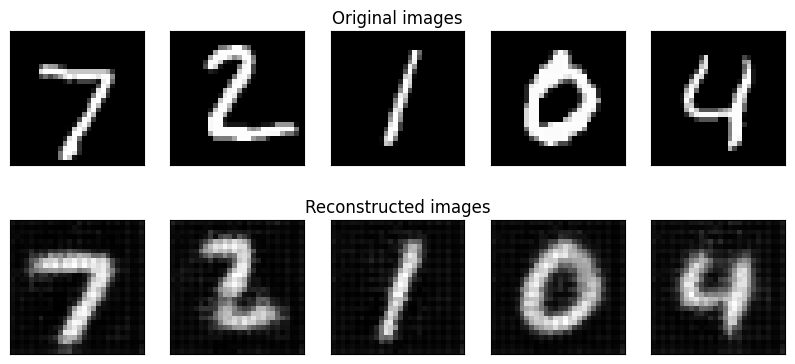

	 partial train loss (single batch): 10057.041992
	 partial train loss (single batch): 9943.378906
	 partial train loss (single batch): 9851.573242
	 partial train loss (single batch): 9862.744141
	 partial train loss (single batch): 9686.083984
	 partial train loss (single batch): 9795.871094
	 partial train loss (single batch): 9864.508789
	 partial train loss (single batch): 10037.552734
	 partial train loss (single batch): 10011.599609
	 partial train loss (single batch): 9551.726562
	 partial train loss (single batch): 9793.875977
	 partial train loss (single batch): 9276.422852
	 partial train loss (single batch): 9736.095703
	 partial train loss (single batch): 9974.014648
	 partial train loss (single batch): 9617.587891
	 partial train loss (single batch): 9669.738281
	 partial train loss (single batch): 9753.239258
	 partial train loss (single batch): 10013.857422
	 partial train loss (single batch): 9667.787109
	 partial train loss (single batch): 9747.118164
	 partial train 

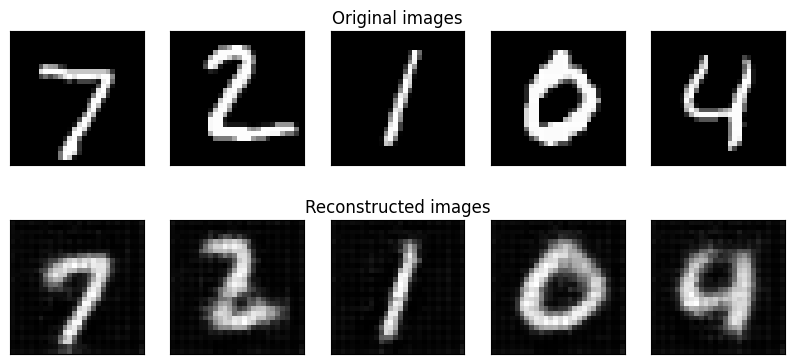

	 partial train loss (single batch): 9560.760742
	 partial train loss (single batch): 9550.009766
	 partial train loss (single batch): 9399.089844
	 partial train loss (single batch): 9470.894531
	 partial train loss (single batch): 9216.764648
	 partial train loss (single batch): 9388.191406
	 partial train loss (single batch): 9442.289062
	 partial train loss (single batch): 9572.808594
	 partial train loss (single batch): 9555.295898
	 partial train loss (single batch): 9206.711914
	 partial train loss (single batch): 9393.590820
	 partial train loss (single batch): 8812.131836
	 partial train loss (single batch): 9292.234375
	 partial train loss (single batch): 9505.345703
	 partial train loss (single batch): 9110.066406
	 partial train loss (single batch): 9188.501953
	 partial train loss (single batch): 9376.572266
	 partial train loss (single batch): 9624.465820
	 partial train loss (single batch): 9201.052734
	 partial train loss (single batch): 9334.110352
	 partial train loss

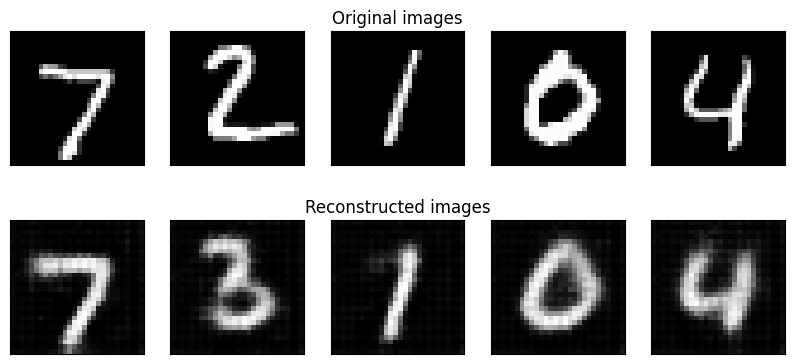

	 partial train loss (single batch): 9251.436523
	 partial train loss (single batch): 9328.591797
	 partial train loss (single batch): 9180.223633
	 partial train loss (single batch): 9261.602539
	 partial train loss (single batch): 9052.766602
	 partial train loss (single batch): 9200.037109
	 partial train loss (single batch): 9227.086914
	 partial train loss (single batch): 9490.582031
	 partial train loss (single batch): 9344.138672
	 partial train loss (single batch): 8958.762695
	 partial train loss (single batch): 9113.688477
	 partial train loss (single batch): 8601.174805
	 partial train loss (single batch): 9096.168945
	 partial train loss (single batch): 9191.355469
	 partial train loss (single batch): 8894.358398
	 partial train loss (single batch): 9049.218750
	 partial train loss (single batch): 9132.042969
	 partial train loss (single batch): 9449.276367
	 partial train loss (single batch): 9012.061523
	 partial train loss (single batch): 9117.529297
	 partial train loss

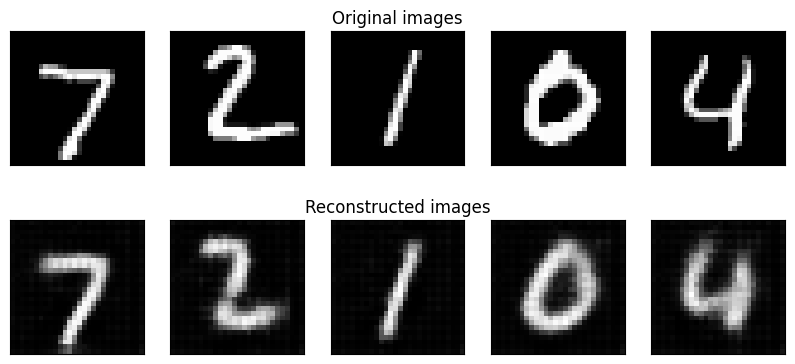

	 partial train loss (single batch): 9078.142578
	 partial train loss (single batch): 9198.507812
	 partial train loss (single batch): 9141.491211
	 partial train loss (single batch): 9083.790039
	 partial train loss (single batch): 8864.819336
	 partial train loss (single batch): 9044.823242
	 partial train loss (single batch): 9107.921875
	 partial train loss (single batch): 9220.214844
	 partial train loss (single batch): 9157.617188
	 partial train loss (single batch): 8834.832031
	 partial train loss (single batch): 9010.228516
	 partial train loss (single batch): 8496.325195
	 partial train loss (single batch): 9083.332031
	 partial train loss (single batch): 9066.123047
	 partial train loss (single batch): 8821.454102
	 partial train loss (single batch): 8998.421875
	 partial train loss (single batch): 8928.712891
	 partial train loss (single batch): 9339.575195
	 partial train loss (single batch): 8941.699219
	 partial train loss (single batch): 8971.637695
	 partial train loss

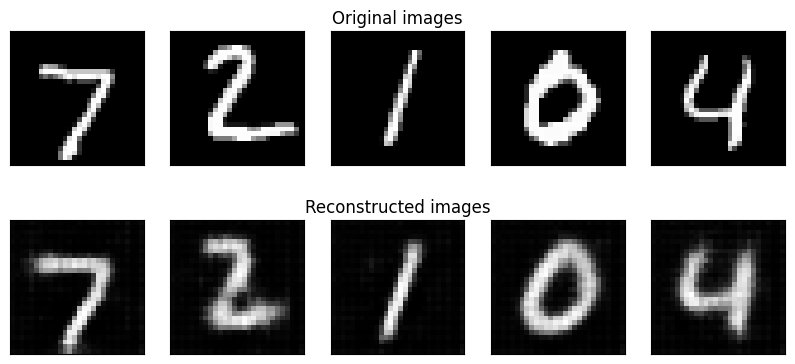

	 partial train loss (single batch): 9069.816406
	 partial train loss (single batch): 9136.125000
	 partial train loss (single batch): 8988.887695
	 partial train loss (single batch): 8985.171875
	 partial train loss (single batch): 8749.201172
	 partial train loss (single batch): 8841.732422
	 partial train loss (single batch): 8993.374023
	 partial train loss (single batch): 9130.496094
	 partial train loss (single batch): 9123.742188
	 partial train loss (single batch): 8737.977539
	 partial train loss (single batch): 8933.898438
	 partial train loss (single batch): 8335.958984
	 partial train loss (single batch): 8842.201172
	 partial train loss (single batch): 8942.667969
	 partial train loss (single batch): 8689.675781
	 partial train loss (single batch): 8917.447266
	 partial train loss (single batch): 8970.025391
	 partial train loss (single batch): 9195.533203
	 partial train loss (single batch): 8761.674805
	 partial train loss (single batch): 8873.180664
	 partial train loss

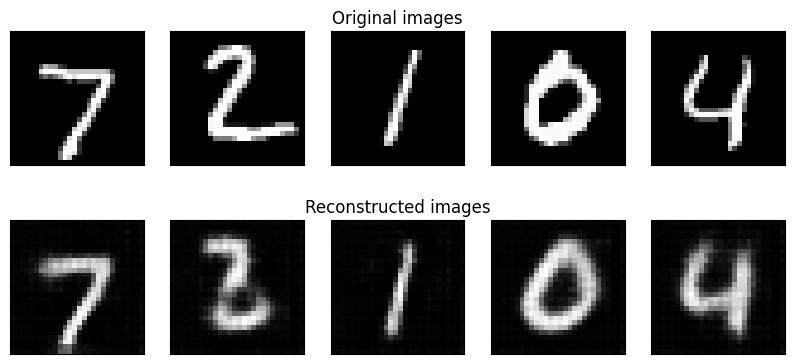

	 partial train loss (single batch): 9027.990234
	 partial train loss (single batch): 9006.839844
	 partial train loss (single batch): 8915.982422
	 partial train loss (single batch): 8896.858398
	 partial train loss (single batch): 8585.011719
	 partial train loss (single batch): 8870.816406
	 partial train loss (single batch): 8906.059570
	 partial train loss (single batch): 9075.184570
	 partial train loss (single batch): 9056.023438
	 partial train loss (single batch): 8673.309570
	 partial train loss (single batch): 8883.385742
	 partial train loss (single batch): 8325.159180
	 partial train loss (single batch): 8832.325195
	 partial train loss (single batch): 8837.767578
	 partial train loss (single batch): 8568.917969
	 partial train loss (single batch): 8790.169922
	 partial train loss (single batch): 8826.473633
	 partial train loss (single batch): 9150.093750
	 partial train loss (single batch): 8743.900391
	 partial train loss (single batch): 8867.216797
	 partial train loss

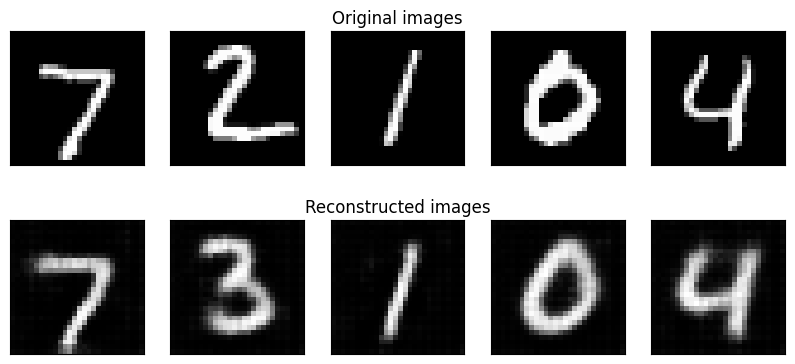

	 partial train loss (single batch): 8900.016602
	 partial train loss (single batch): 8985.193359
	 partial train loss (single batch): 8941.980469
	 partial train loss (single batch): 8847.977539
	 partial train loss (single batch): 8696.422852
	 partial train loss (single batch): 8814.394531
	 partial train loss (single batch): 8866.822266
	 partial train loss (single batch): 9088.950195
	 partial train loss (single batch): 8908.750977
	 partial train loss (single batch): 8602.693359
	 partial train loss (single batch): 8838.576172
	 partial train loss (single batch): 8194.699219
	 partial train loss (single batch): 8650.676758
	 partial train loss (single batch): 8798.449219
	 partial train loss (single batch): 8544.467773
	 partial train loss (single batch): 8740.798828
	 partial train loss (single batch): 8747.324219
	 partial train loss (single batch): 9098.542969
	 partial train loss (single batch): 8635.650391
	 partial train loss (single batch): 8742.589844
	 partial train loss

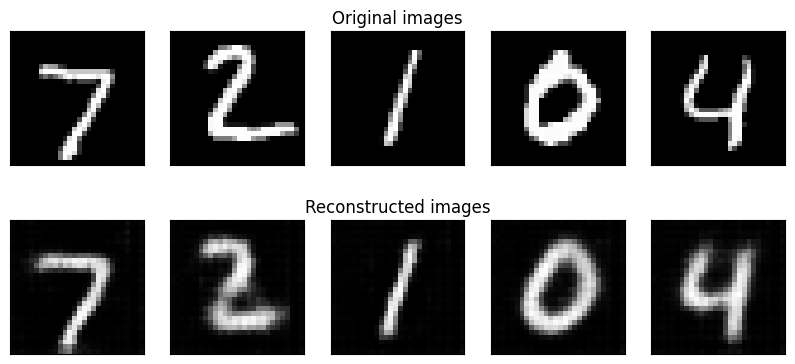

	 partial train loss (single batch): 8816.230469
	 partial train loss (single batch): 8972.746094
	 partial train loss (single batch): 8788.735352
	 partial train loss (single batch): 8839.173828
	 partial train loss (single batch): 8507.594727
	 partial train loss (single batch): 8862.412109
	 partial train loss (single batch): 8883.441406
	 partial train loss (single batch): 8936.145508
	 partial train loss (single batch): 8973.257812
	 partial train loss (single batch): 8563.086914
	 partial train loss (single batch): 8804.837891
	 partial train loss (single batch): 8189.020508
	 partial train loss (single batch): 8650.251953
	 partial train loss (single batch): 8701.115234
	 partial train loss (single batch): 8486.328125
	 partial train loss (single batch): 8731.227539
	 partial train loss (single batch): 8745.000000
	 partial train loss (single batch): 9042.964844
	 partial train loss (single batch): 8706.269531
	 partial train loss (single batch): 8678.308594
	 partial train loss

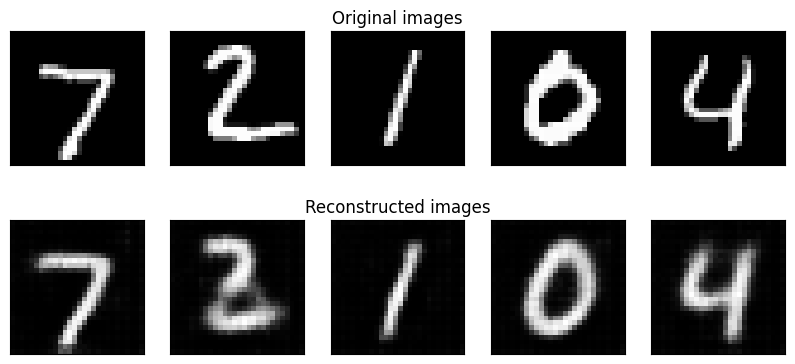

	 partial train loss (single batch): 8814.114258
	 partial train loss (single batch): 8891.995117
	 partial train loss (single batch): 8802.259766
	 partial train loss (single batch): 8771.832031
	 partial train loss (single batch): 8548.430664
	 partial train loss (single batch): 8698.352539
	 partial train loss (single batch): 8846.258789
	 partial train loss (single batch): 8940.748047
	 partial train loss (single batch): 8891.888672
	 partial train loss (single batch): 8554.200195
	 partial train loss (single batch): 8763.080078
	 partial train loss (single batch): 8150.222168
	 partial train loss (single batch): 8612.575195
	 partial train loss (single batch): 8737.490234
	 partial train loss (single batch): 8495.443359
	 partial train loss (single batch): 8663.891602
	 partial train loss (single batch): 8634.849609
	 partial train loss (single batch): 8881.396484
	 partial train loss (single batch): 8564.435547
	 partial train loss (single batch): 8583.898438
	 partial train loss

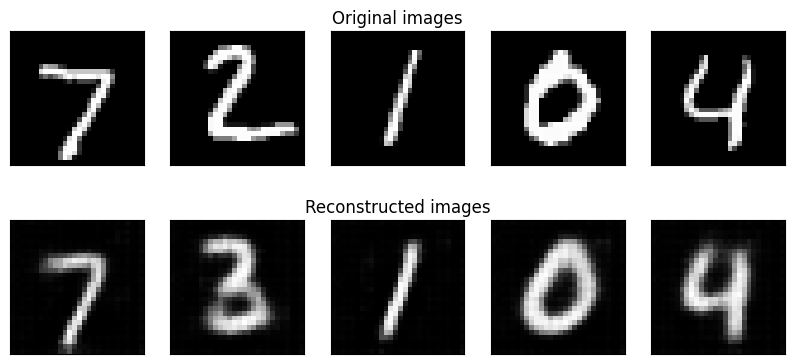

	 partial train loss (single batch): 8811.273438
	 partial train loss (single batch): 8942.966797
	 partial train loss (single batch): 8699.632812
	 partial train loss (single batch): 8823.583984
	 partial train loss (single batch): 8505.353516
	 partial train loss (single batch): 8718.932617
	 partial train loss (single batch): 8787.847656
	 partial train loss (single batch): 8845.494141
	 partial train loss (single batch): 8794.989258
	 partial train loss (single batch): 8512.598633
	 partial train loss (single batch): 8740.173828
	 partial train loss (single batch): 8124.696289
	 partial train loss (single batch): 8499.932617
	 partial train loss (single batch): 8694.042969
	 partial train loss (single batch): 8408.756836
	 partial train loss (single batch): 8643.546875
	 partial train loss (single batch): 8593.222656
	 partial train loss (single batch): 8948.171875
	 partial train loss (single batch): 8504.429688
	 partial train loss (single batch): 8567.226562
	 partial train loss

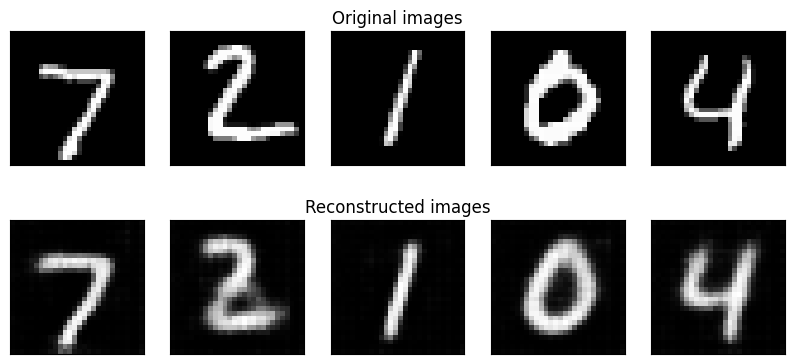

	 partial train loss (single batch): 8723.590820
	 partial train loss (single batch): 8869.424805
	 partial train loss (single batch): 8735.856445
	 partial train loss (single batch): 8725.558594
	 partial train loss (single batch): 8412.577148
	 partial train loss (single batch): 8714.712891
	 partial train loss (single batch): 8745.232422
	 partial train loss (single batch): 8914.984375
	 partial train loss (single batch): 8875.191406
	 partial train loss (single batch): 8454.185547
	 partial train loss (single batch): 8644.073242
	 partial train loss (single batch): 8067.648926
	 partial train loss (single batch): 8500.055664
	 partial train loss (single batch): 8631.916016
	 partial train loss (single batch): 8364.427734
	 partial train loss (single batch): 8545.690430
	 partial train loss (single batch): 8582.194336
	 partial train loss (single batch): 8905.066406
	 partial train loss (single batch): 8540.153320
	 partial train loss (single batch): 8524.966797
	 partial train loss

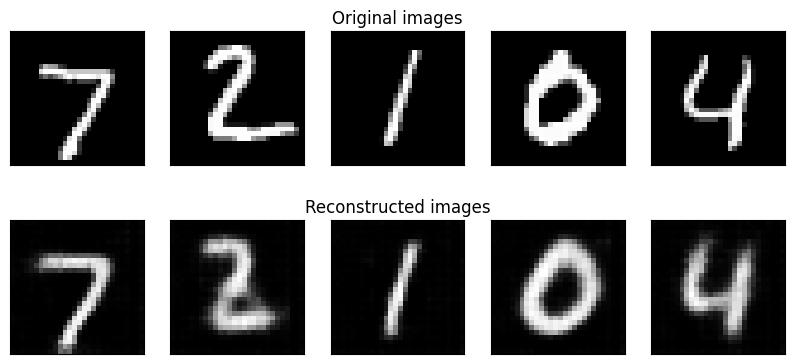

	 partial train loss (single batch): 8652.430664
	 partial train loss (single batch): 8900.658203
	 partial train loss (single batch): 8675.549805
	 partial train loss (single batch): 8693.458984
	 partial train loss (single batch): 8407.573242
	 partial train loss (single batch): 8650.011719
	 partial train loss (single batch): 8782.817383
	 partial train loss (single batch): 8858.507812
	 partial train loss (single batch): 8803.312500
	 partial train loss (single batch): 8440.310547
	 partial train loss (single batch): 8597.448242
	 partial train loss (single batch): 8026.763672
	 partial train loss (single batch): 8493.631836
	 partial train loss (single batch): 8572.475586
	 partial train loss (single batch): 8385.736328
	 partial train loss (single batch): 8509.271484
	 partial train loss (single batch): 8561.958984
	 partial train loss (single batch): 8850.603516
	 partial train loss (single batch): 8437.130859
	 partial train loss (single batch): 8514.511719
	 partial train loss

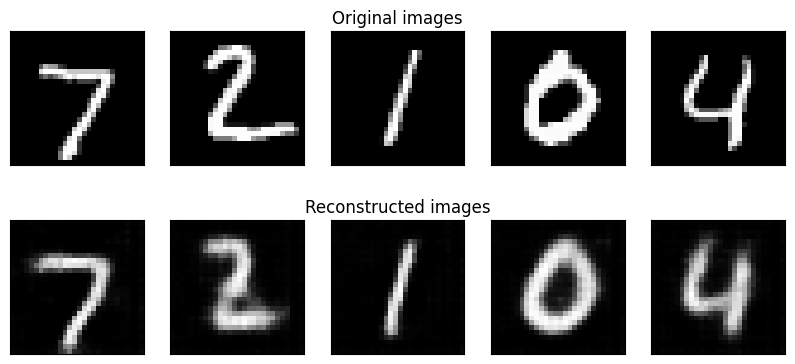

	 partial train loss (single batch): 8682.408203
	 partial train loss (single batch): 8758.517578
	 partial train loss (single batch): 8613.289062
	 partial train loss (single batch): 8733.675781
	 partial train loss (single batch): 8417.913086
	 partial train loss (single batch): 8571.253906
	 partial train loss (single batch): 8655.875977
	 partial train loss (single batch): 8901.507812
	 partial train loss (single batch): 8787.824219
	 partial train loss (single batch): 8296.022461
	 partial train loss (single batch): 8601.859375
	 partial train loss (single batch): 7946.161133
	 partial train loss (single batch): 8481.410156
	 partial train loss (single batch): 8567.245117
	 partial train loss (single batch): 8360.258789
	 partial train loss (single batch): 8518.525391
	 partial train loss (single batch): 8547.671875
	 partial train loss (single batch): 8914.808594
	 partial train loss (single batch): 8417.800781
	 partial train loss (single batch): 8474.720703
	 partial train loss

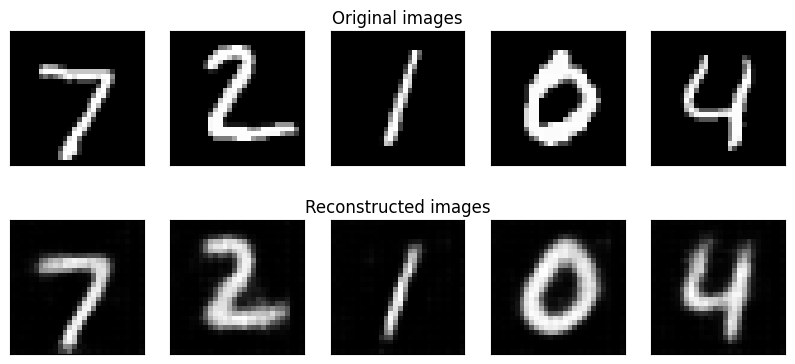

	 partial train loss (single batch): 8702.338867
	 partial train loss (single batch): 8728.910156
	 partial train loss (single batch): 8628.998047
	 partial train loss (single batch): 8569.675781
	 partial train loss (single batch): 8416.669922
	 partial train loss (single batch): 8535.566406
	 partial train loss (single batch): 8660.996094
	 partial train loss (single batch): 8749.828125
	 partial train loss (single batch): 8747.232422
	 partial train loss (single batch): 8368.046875
	 partial train loss (single batch): 8588.972656
	 partial train loss (single batch): 7934.361816
	 partial train loss (single batch): 8418.773438
	 partial train loss (single batch): 8484.649414
	 partial train loss (single batch): 8313.411133
	 partial train loss (single batch): 8485.391602
	 partial train loss (single batch): 8517.939453
	 partial train loss (single batch): 8769.454102
	 partial train loss (single batch): 8468.259766
	 partial train loss (single batch): 8397.620117
	 partial train loss

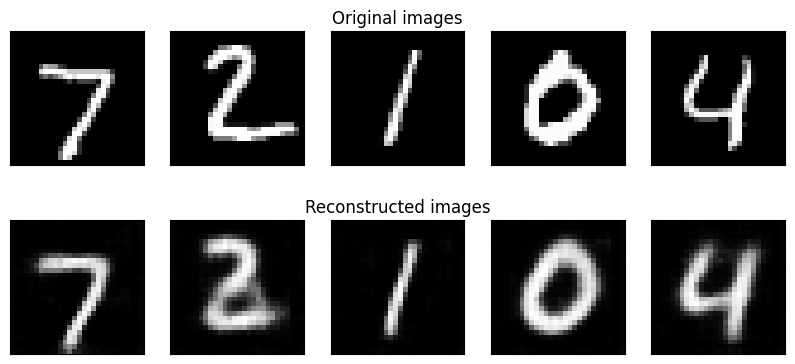

	 partial train loss (single batch): 8562.744141
	 partial train loss (single batch): 8787.183594
	 partial train loss (single batch): 8639.435547
	 partial train loss (single batch): 8654.364258
	 partial train loss (single batch): 8414.619141
	 partial train loss (single batch): 8650.126953
	 partial train loss (single batch): 8711.621094
	 partial train loss (single batch): 8807.281250
	 partial train loss (single batch): 8731.475586
	 partial train loss (single batch): 8323.999023
	 partial train loss (single batch): 8579.907227
	 partial train loss (single batch): 8017.252930
	 partial train loss (single batch): 8412.752930
	 partial train loss (single batch): 8542.221680
	 partial train loss (single batch): 8373.696289
	 partial train loss (single batch): 8520.445312
	 partial train loss (single batch): 8496.963867
	 partial train loss (single batch): 8812.210938
	 partial train loss (single batch): 8380.263672
	 partial train loss (single batch): 8451.064453
	 partial train loss

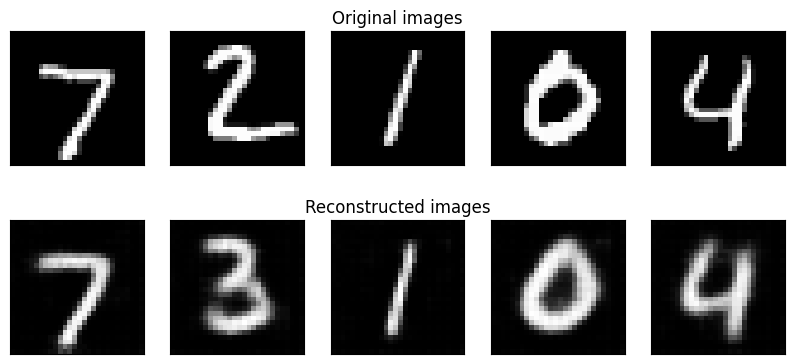

	 partial train loss (single batch): 8515.189453
	 partial train loss (single batch): 8737.727539
	 partial train loss (single batch): 8616.114258
	 partial train loss (single batch): 8604.589844
	 partial train loss (single batch): 8385.609375
	 partial train loss (single batch): 8549.047852
	 partial train loss (single batch): 8623.881836
	 partial train loss (single batch): 8678.515625
	 partial train loss (single batch): 8716.504883
	 partial train loss (single batch): 8362.933594
	 partial train loss (single batch): 8499.334961
	 partial train loss (single batch): 7972.677734
	 partial train loss (single batch): 8361.443359
	 partial train loss (single batch): 8551.388672
	 partial train loss (single batch): 8296.472656
	 partial train loss (single batch): 8471.446289
	 partial train loss (single batch): 8412.900391
	 partial train loss (single batch): 8726.115234
	 partial train loss (single batch): 8381.796875
	 partial train loss (single batch): 8349.843750
	 partial train loss

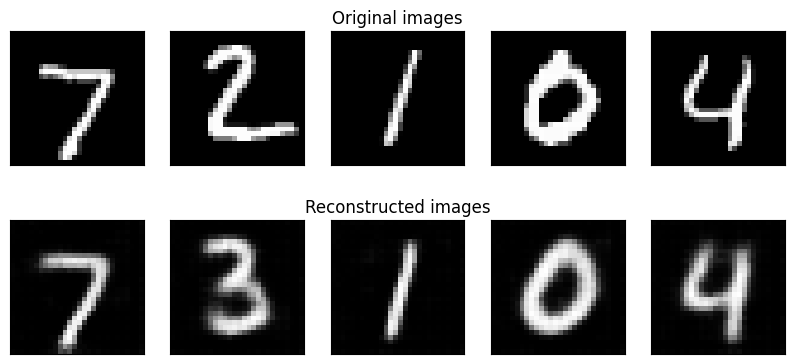

CPU times: user 30 s, sys: 2.56 s, total: 32.5 s
Wall time: 29.5 s


In [13]:
%%time

num_epochs = 20 # 50
history_vae={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):

    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    history_vae['train_loss'].append(train_loss)
    history_vae['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    plot_ae_outputs(vae.encoder,vae.decoder,n=5)

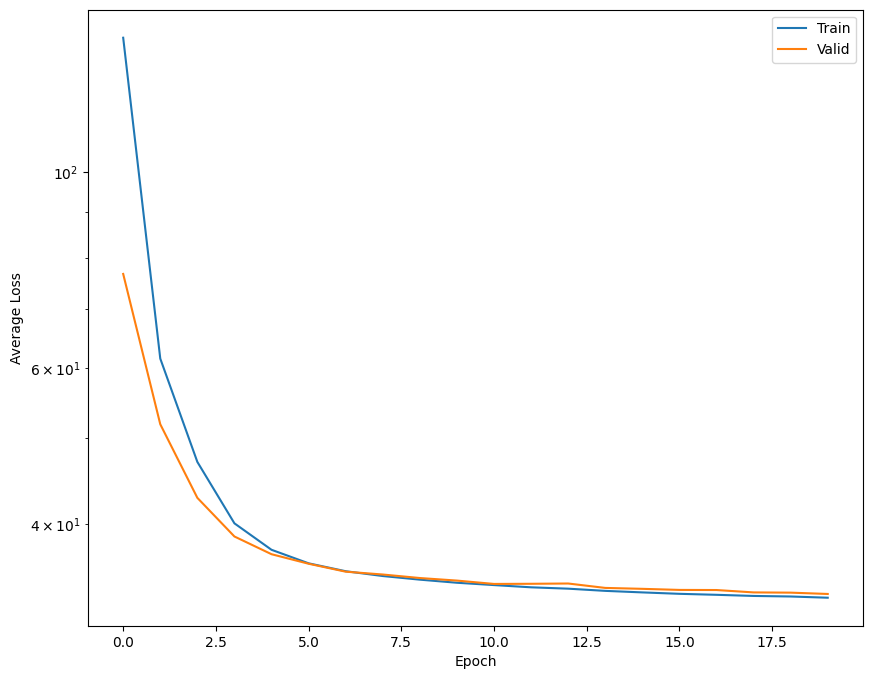

In [14]:
# Plot training performance
test_epoch(vae,device,test_loader)
plt.figure(figsize=(10,8))
plt.semilogy(history_vae['train_loss'], label='Train')
plt.semilogy(history_vae['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4.Visualize latent space

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3173.68it/s]


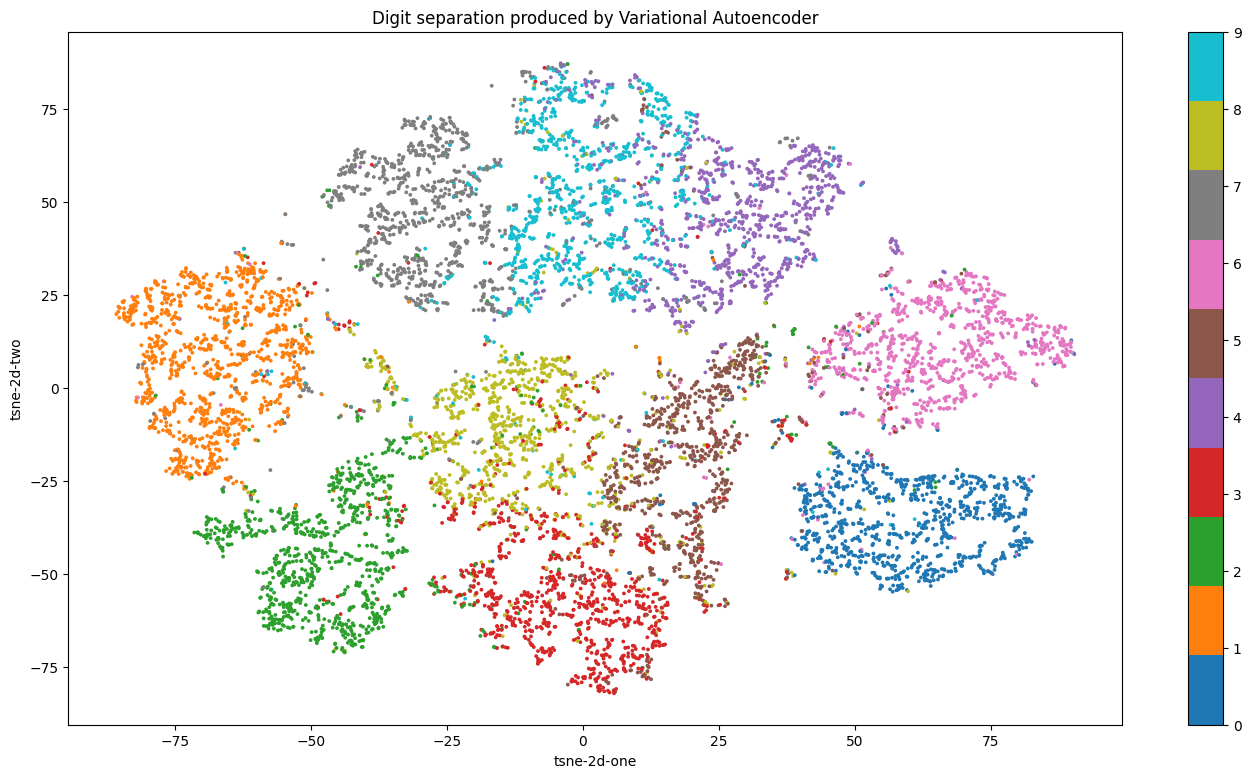

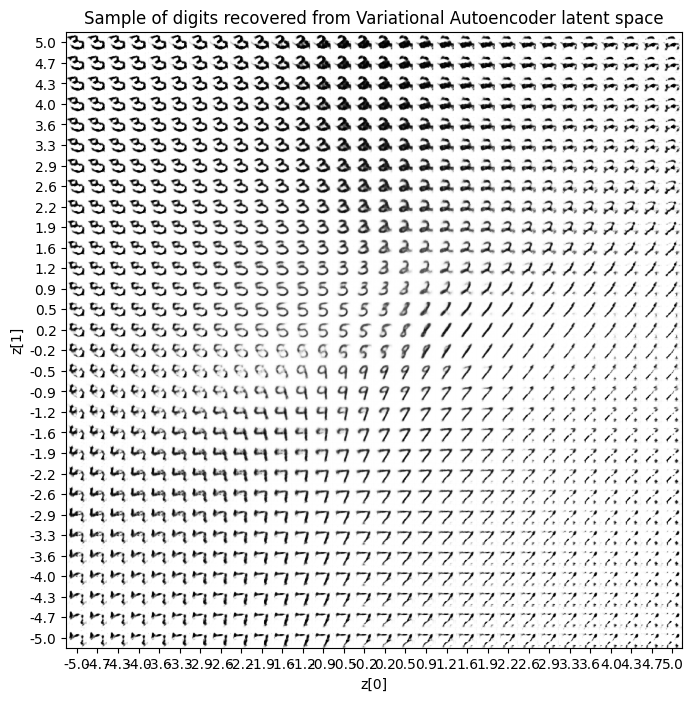

In [15]:
def plot_results(model, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        vae.eval()
        with torch.no_grad():
            encoded_img  = model.encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            # coords = [xj, yi, 0, 0] # Use latent_dim
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = model.decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    # plt.savefig(filename)
    plt.show()

plot_results(vae, test_dataset, rx=(-5, 5), ry=(-5, 5), model_name="Variational Autoencoder")

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table